In [1]:
import numpy as np
from numpy.random import randn, permutation, seed
from numpy.linalg import norm
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import time

In [2]:
import sys
sys.path.append("..")
#from pp5.stats import tw_test

In [3]:
import random
from typing import Any, Dict, List, Tuple, Union, Callable, Optional, Sequence
from itertools import product
import numba
import numpy as np
from numpy.random import permutation
from scipy.spatial.distance import pdist, squareform

In [4]:
@numba.jit(nopython=True, parallel=False)
def mmd_statistic(K: np.ndarray, nx: int, ny: int) -> float:
    """
    Calculates T statistic of a distance matrix
    :param K: Matrix of inner products of two pooled samples (X and Y) of
        shape (nx+ny, nx+ny).
    :param nx: Number of observations from X.
    :param ny: Number of observations from Y.
    :return: The MMD statistic.
    """
    sum_X = np.sum(K[0:nx, 0:nx]) / nx / nx
    sum_Y = np.sum(K[nx:, nx:]) / ny / ny
    sum_XY = np.sum(K[nx:, 0:nx]) / nx / ny
    return float(sum_X + sum_Y - 2. * sum_XY)

@numba.jit(nopython=True, parallel=False)
def tw2_statistic(D: np.ndarray, nx: int, ny: int) -> float:
    """
    Calculates T statistic of a distance matrix
    :param D: Matrix of squared distances of two pooled samples (X and Y) of
        shape (nx+ny, nx+ny).
    :param nx: Number of observations from X.
    :param ny: Number of observations from Y.
    :return: The T2 statistic.
    """
    factor = (nx + ny) / nx / ny
    sum_X = np.sum(D[0:nx, 0:nx])
    sum_Y = np.sum(D[nx:, nx:])
    sum_Z = np.sum(D)
    enumerator = sum_Z / (nx + ny) - sum_X / nx - sum_Y / ny
    denumerator = (sum_X / (nx ** 2) / (nx - 1)) + (sum_Y / (ny ** 2) / (ny - 1))
    if denumerator < 1e-12:  # prevent division by zero
        return 0.0
    return float(factor * enumerator / denumerator)

In [5]:

def paired_test(
    X: np.ndarray,
    Y: np.ndarray,
    k: int = 1000,
    metric: Optional[Union[str, Callable]] = "sqeuclidean",
    kernel: Callable = lambda d: d,
    statistic: Callable = mmd_statistic,
) -> Tuple[float, float]:
    """
    Calculates the MMD statistic based on distances.
    :param X: (n, Nx) array containing a sample X, where Nx is the number of
        observations in the sample and n is the dimension of each observation.
    :param Y: (n, Ny) array containing sample Y with Ny observations of dimension n.
    :param k: number of permutations for significance evaluation
    :param metric: A distance metric. Any of the distance metrics supported by
        :meth:`scipy.spatial.distance.pdist` can be used. Default is squared-euclidean.
        Can also be a callable that accepts two observations in order to use a custom
        metric.
    :param kernel: A kernel applied to the pairwise distances. Identity by default.
    :param statistic: A callable describing the statistic.
    :return: statistic, p-value (significance).
    """
    # sample sizes
    nx = X.shape[1]
    ny = Y.shape[1]

    # pooled vectors
    Z = np.hstack((X, Y))

    # pairwise distances
    D = squareform(pdist(Z.T, metric=metric))
    
    # Inner products
    K = kernel(D)

    t2, p = _paired_test_inner(statistic, K, nx, ny, k)
    return t2, p


@numba.jit(nopython=True, parallel=False)  # parallel doesn't seem to help
def _paired_test_inner(statistic, K: np.ndarray, nx: int, ny: int, k: int) -> Tuple[float, float]:
    """
    Calculates p-value based on Tw^2 test.
    :param K: Matrix of inner products of two pooled samples (X and Y) of
        shape (nx+ny, nx+ny).
    :param nx: Number of observations from X.
    :param ny: Number of observations from Y.
    :param k: Number of permutations for significance evaluation.
    :return: MMD statistic of un-permuted distances, and p-value.
    """
    if nx < 2 or ny < 2:
        raise ValueError("MMD test requires at least two observations in each sample")

    t2 = statistic(K, nx, ny)
    ss = np.zeros(k)
    for i in range(k):
        idx = permutation(nx + ny)
        t2_perm = statistic(K[idx, :][:, idx], nx, ny)
        if t2 <= t2_perm:
            ss[i] = 1

    p = float(np.mean(ss))
    return t2, p

In [6]:
def mmd_test(
    X: np.ndarray,
    Y: np.ndarray,
    k: int = 1000,
    metric: Optional[Union[str, Callable]] = "sqeuclidean",
    sigma: float = 1.
):
    kernel = lambda d: np.exp(-0.5*(d**2)/sigma**2)
    return paired_test(X, Y, k, metric, kernel, mmd_statistic)
    
def tw_test(
    X: np.ndarray,
    Y: np.ndarray,
    k: int = 1000,
    metric: Optional[Union[str, Callable]] = "sqeuclidean",
):
    kernel = lambda x: x
    return paired_test(X, Y, k, metric, kernel, tw2_statistic)
    
        

In [7]:
"""
Data generators. Yield tuples of the form
(nx, ny), (params), trial, X, Y
"""
    
def generate_shifted(dims: int = 2, nsample: Tuple[int,...]=(10, 25), trials: int = 10):
    for dmu in np.linspace(0,1,21):
        for nx in nsample:     # number of samples in X
            ny = nx
            for trial in range(trials):
                seed(trial)
                mu = np.array([0, dmu])
                X = randn(dims, nx)
                Y = randn(dims, ny) + mu[:, None]
                yield ((nx, ny), (norm(mu), ), trial, X, Y)

def generate_scaled(dims: int = 2, nsample: Tuple[int,...]=(10, 25), trials: int = 10):                    
    for scale in np.linspace(0.5,2,21):
        for nx in nsample:     
            ny = nx
            for trial in range(trials):
                seed(trial)
                X = randn(dims, nx)
                Y = randn(dims, ny)*scale   
                yield ((nx, ny), (scale, ), trial, X, Y)
                        
def generate_aniso(dims: int = 2, nsample: Tuple[int,...]=(10, 25), trials: int = 10):                    
    for aniso in np.linspace(0.1,10,21):
        for nx in nsample:     
            ny = nx
            for trial in range(trials):
                seed(trial)
                X = randn(dims, nx)
                Y = randn(dims, ny)*np.array([np.sqrt(aniso), 1/np.sqrt(aniso)])[:, None]
                yield ((nx, ny), (aniso, ), trial, X, Y)
                        
def generate_rot(dims: int = 2, nsample: Tuple[int,...]=(10, 25), trials: int = 10):        
    aniso = 5
    for rot in np.linspace(0, np.pi/4, 21):
        for nx in nsample:     
            ny = nx
            for trial in range(trials):
                seed(trial)
                X = randn(dims, nx)*np.array([np.sqrt(aniso), 1/np.sqrt(aniso)])[:, None]
                Y = randn(dims, ny)*np.array([np.sqrt(aniso), 1/np.sqrt(aniso)])[:, None]
                Y = np.array([
                    [np.cos(rot), np.sin(rot)],
                    [-np.sin(rot), np.cos(rot)],
                ]) @ Y
                yield ((nx, ny), (rot*180/np.pi, ), trial, X, Y)

In [8]:
def run_tests(gen, tests, k: int = 100):
    
    results = {}
    start = True
    for nsample, param, trial, X, Y in gen:

        nx, ny = nsample
        param = tuple(param)

        if trial == 0:
            if not start:
                # calculate means and stds
                results[(nsample, param)] = {
                    'stats': [(np.mean(s), np.std(s)) for s in stats],
                    'pvals': [(np.mean(s), np.std(s)) for s in pvals],
                    'times': [(np.mean(s), np.std(s)) for s in times],
                }
            stats = [[] for _ in range(len(tests))]
            pvals = [[] for _ in range(len(tests))]
            times = [[] for _ in range(len(tests))]
            start = False

        for n, test in enumerate(tests):
            t_start = time.time()
            s, p = test(X, Y, k)
            t_end = time.time()
            deltat = 1000*(t_end-t_start) 
            stats[n].append(s)
            pvals[n].append(p)
            times[n].append(deltat)
            
    return results

In [9]:
dims = 2
nsample = (25, )
ntrials = 10
niters = 100

gens = {
    'shift': generate_shifted(dims=dims, nsample=nsample, trials=ntrials),
    'scale': generate_scaled(dims=dims, nsample=nsample, trials=ntrials),
    'aniso': generate_aniso(dims=dims, nsample=nsample, trials=ntrials),
    'rotation': generate_rot(dims=dims, nsample=nsample, trials=ntrials),
}
tests = {
    'tw': tw_test,
    'mmd': mmd_test,
}

results = {
    param: run_tests(gen, [*tests.values()], k=niters)
    for param, gen in gens.items()
}

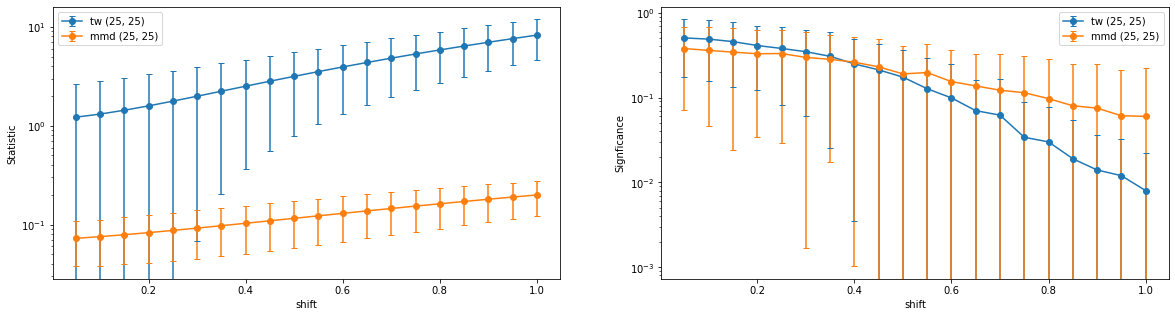

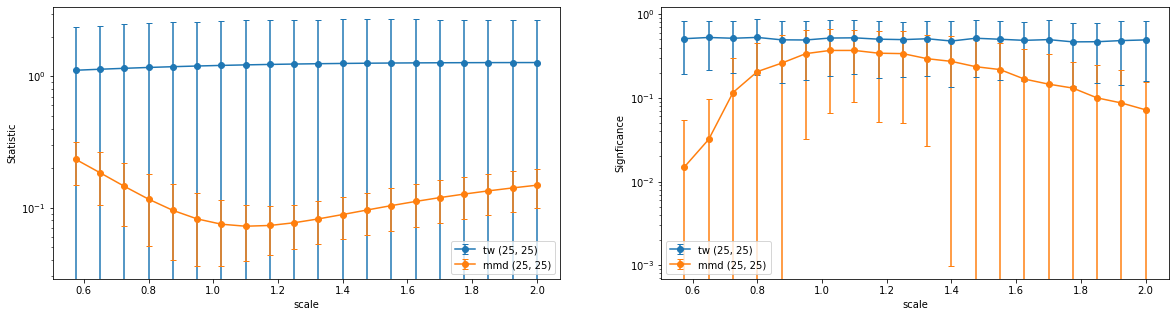

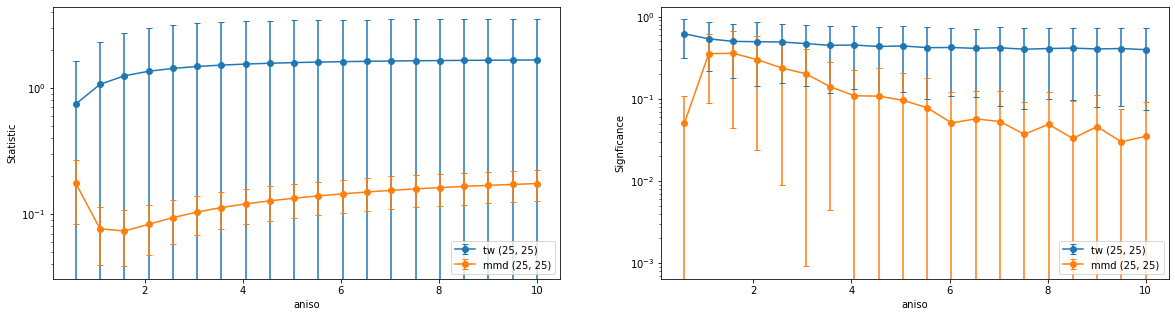

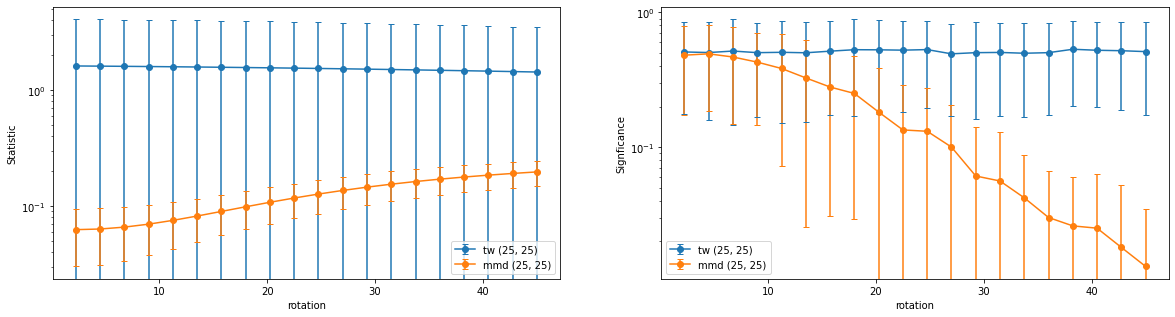

In [10]:
keys = {
    'stats': ('Statistic', 'log'), # linear
    'pvals': ('Signficance', 'log'),
}
        

for param_name in results.keys():
    result = results[param_name]

    # Select max sample sie
    ns = {ns for ns, param in result.keys()}
    ns = (sorted(ns)[-1], )
    for n in ns:
        plt.figure(figsize=(20,5))
        param = [param[0] for ns, param in result.keys() if ns == n]
        for k, (key, (label, scale)) in enumerate(keys.items()):
            mean_stat = np.array([
                [v[0] for v in val[key]]
                for (ns, param), val in result.items() if ns == n
            ])
            std_stat = np.array([
                [v[1] for v in val[key]]
                for (ns, param), val in result.items() if ns == n
            ])
            plt.subplot(1,len(keys),k+1)
            for nt, t in enumerate(tests.keys()):
                plt.errorbar(param, mean_stat[:,nt], yerr=std_stat[:,nt], capsize=3, marker='o', label=t)
            plt.legend([f"{k} {n}" for k in tests.keys()])
            plt.ylabel(label)
            plt.xlabel(param_name)
            plt.yscale(scale)
